# PHYS20762 - Project 3 - Monte Carlo Method

Alexander Stansfield <br>
University of Manchester <br>
May 2022

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.style.use('default')

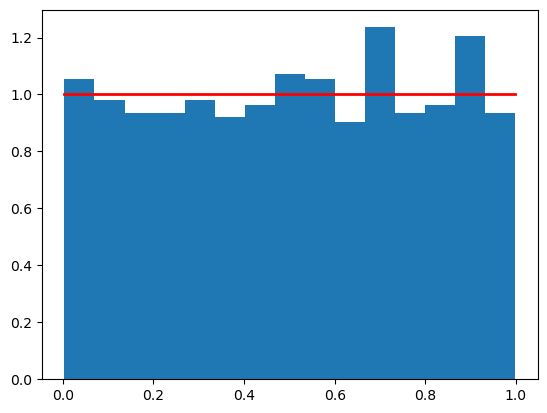

In [10]:
s  = np.random.uniform(0, 1, 1000)
count, bins, ignored = plt.hist(s, 15, density = True)
plt.plot(bins, np.ones_like(bins), linewidth = 2, color = 'red')
plt.show()